PROJECT OBJECTIVE: The need is to build a NLP classifier which can use input text parameters to determine the label/s of of the blog.

Steps and tasks:
1. Import and analyse the data set.
2. Perform data pre-processing on the data:
    - Data cleansing by removing unwanted characters, spaces, stop words etc. Convert text to lowercase.
    - Target/label merger and transformation
    - Train and test split
    - Vectorisation, etc.
3. Design, train, tune and test the best text classifier.
4. Display and explain detail the classification report
5. Print the true vs predicted labels for any 5 entries from the dataset.


Hint: The aim here Is to import the text, process it such a way that it can be taken

### Approach Taken:
- Importing Libraries and Data
- EDA
    - Exploring and visualizing the data
- Data Processing
    - Null values
    - Converting sequential age data to groups of 3
    - Undersampling & Oversampling
        - as few topics has very high presence compared to others and creating a high class imbalance
        - Truncated the classes having high class dominance
    - Data cleansing by removing unwanted characters, spaces, stop words etc. Convert text to lowercase.
    - Target/label merger and transformation
    - Train and test split
    - Vectorisation
        - Countvectorizer
        - tfidfvectorizer
        - we have tried out both but it was suggested to use countvectorizer over tfidf in many forums and libraries
    - Feature selection
        - Chi-square test measures dependence between stochastic variables
    - Multilabel binarizer for target
        
- Model Creation
    - OneVsRestClassifier - used for multi class classification with different algos
        - MultinimialNB
        - BernoulliNB
        - RandomForest
        - Dense Network
        
- Additiona Details
    - Attempted the models with and without undersampling and with undersampling, we got comparatively better results for unndersampled data, otherwise models were becoming biased towards few topic


### Import Libraries

In [1]:
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import json
import pickle

import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
import random
from nltk.chat.util import Chat, reflections
import copy

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

### Importing blogs csv

In [3]:
blogs=pd.read_csv('blogtext.csv')

In [4]:
blogs.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


In [5]:
#analyze the data

In [6]:
blogs.shape

(681284, 7)

In [7]:
blogs.sample(5)

,id,gender,age,topic,sign,date,text
429012,1856131,male,24,indUnk,Gemini,"28,June,2004",Green Bay will make wild card ... I kno...
519963,3636538,female,25,indUnk,Taurus,"15,June,2004",They arrived late at night in a city th...
632237,634667,male,24,indUnk,Libra,"10,June,2004",Leaving Erith The Lady of the...
243278,3446170,male,27,Law,Cancer,"08,June,2004","Sorry folks, my baby's away and can't c..."
201771,1603874,male,41,Internet,Scorpio,"02,July,2004","urlLink Madagascar ? So, this i..."


In [8]:
blogs.describe().T

,count,mean,std,min,25%,50%,75%,max
id,681284.0,2.397802e+06,1.247723e+06,5114.0,1239610.0,2607577.0,3525660.0,4337650.0
age,681284.0,2.393233e+01,7.786009e+00,13.0,17.0,24.0,26.0,48.0


In [9]:
blogs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681284 entries, 0 to 681283
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      681284 non-null  int64 
 1   gender  681284 non-null  object
 2   age     681284 non-null  int64 
 3   topic   681284 non-null  object
 4   sign    681284 non-null  object
 5   date    681284 non-null  object
 6   text    681284 non-null  object
dtypes: int64(2), object(5)
memory usage: 36.4+ MB


- Csv has 681,284 entries
- 7 columns
- text field contains the blog details
- sign, age, gender, topic are major labels which represnts the features of the author
- Id and date are fields to map details uniquely hence will not be beneficial while identifying features

In [10]:
blogs.gender.value_counts()

male      345193
female    336091
Name: gender, dtype: int64

<AxesSubplot:xlabel='gender', ylabel='count'>

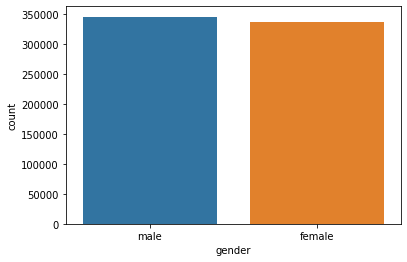

In [11]:
sns.countplot(blogs['gender'])

- Gender distribution seems even for male and female
- no null values present

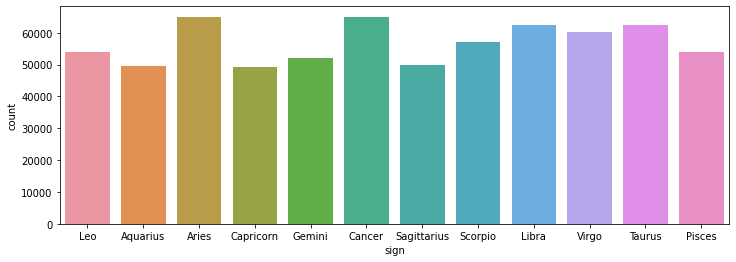

In [12]:
plt.figure(figsize=(12,4))
sns.countplot(blogs['sign'])
plt.show()

In [13]:
blogs.sign.value_counts()

Cancer         65048
Aries          64979
Taurus         62561
Libra          62363
Virgo          60399
Scorpio        57161
Pisces         54053
Leo            53811
Gemini         51985
Sagittarius    50036
Aquarius       49687
Capricorn      49201
Name: sign, dtype: int64

- entries are distributed across all 12 signs
- No null values

In [14]:
blogs.age.value_counts()

17    80859
24    80071
23    72889
16    72708
25    67051
26    55312
27    46124
15    41767
14    27400
34    21347
33    17584
35    17462
36    14229
13    13133
37     9317
38     7545
39     5556
40     5016
45     4482
43     4230
41     3738
48     3572
42     2908
46     2733
47     2207
44     2044
Name: age, dtype: int64

<AxesSubplot:xlabel='age'>

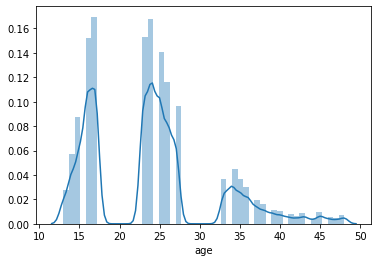

In [15]:
sns.distplot(blogs['age'])

- Make age group
- All bloggers included in the corpus fall into one of three age groups:
    - 8240 "10s" blogs (ages 13-17),
    - 8086 "20s" blogs(ages 23-27) and
    - 2994 "30s" blogs (ages 33-47)


- Age distribution is a bit skwed
- we can observe high concentration of for 10s and 20s compared to 30s age group
- no null values

- Creating a new label for age and converting the ages into 3 group

In [16]:
bins = pd.IntervalIndex.from_tuples([(12,17), (22, 27), (32, 47)])
labels=['10s','20s','30s']
#blogs['AgeGroup']=pd.cut(blogs['age'],bins=bins)
blogs['AgeGroup']=pd.cut(blogs['age'],bins=[13,18,28,49],labels=labels,right=False)

In [17]:
blogs.AgeGroup.value_counts()

20s    321447
10s    235867
30s    123970
Name: AgeGroup, dtype: int64

In [18]:
pd.crosstab(blogs.AgeGroup,blogs.gender)

gender,female,male
AgeGroup,,
10s,115389,120478
20s,162075,159372
30s,58627,65343


In [19]:
blogs.head()

,id,gender,age,topic,sign,date,text,AgeGroup
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,...",10s
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...,10s
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...,10s
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!,10s
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...,30s


In [20]:
blogs.topic.value_counts()

indUnk                     251015
Student                    153903
Technology                  42055
Arts                        32449
Education                   29633
Communications-Media        20140
Internet                    16006
Non-Profit                  14700
Engineering                 11653
Law                          9040
Publishing                   7753
Science                      7269
Government                   6907
Consulting                   5862
Religion                     5235
Fashion                      4851
Marketing                    4769
Advertising                  4676
BusinessServices             4500
Banking                      4049
Chemicals                    3928
Telecommunications           3891
Accounting                   3832
Military                     3128
Museums-Libraries            3096
Sports-Recreation            3038
HumanResources               3010
RealEstate                   2870
Transportation               2326
Manufacturing 

In [21]:
len(blogs[blogs.topic=='indUnk'])

251015

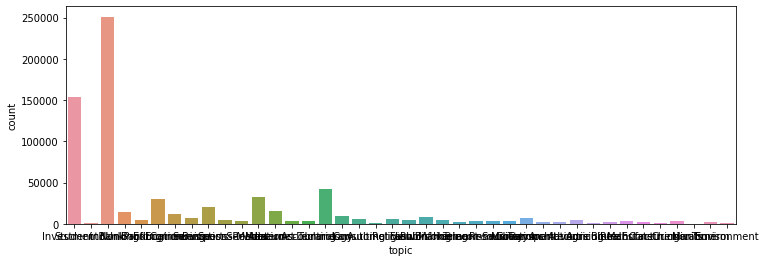

In [22]:
plt.figure(figsize=(12,4))
sns.countplot(blogs.topic)
plt.show()

- 2 topics has high concentration and hence we might get screwed result towards these two topics
- Class imbalance will impact result
- With default data set we attempted for model creation and noticed pathetic classification values
- Hence we came back and trying to under sample the values. We can do over sampling as well to get better balance.
- Experimenting with column values and reducing evrything for dominant topic. This will reduce the values dramatically along with importan data as well.

In [23]:
allTopics=blogs.topic.unique()
allTopics[1]

'InvestmentBanking'

- For resampling, we have chosenn to undersample few topics for few reasons.
    - Keeping around 10k samples on each topic will give eqal playground for all topics
    - we will take a chip of it while doing model creation
- we undersampled and oversampled, to get eqal importance on each topics. This will truncate lot of important data from dominating toppics but we couldnt oversample other topics as it will explode the size and our system will not be able to handle it

In [24]:

from sklearn.utils import resample

downsampled=pd.DataFrame()

for val in allTopics:
    toUndersample = blogs[blogs.topic==val]
    if(len(toUndersample)>10000):
        # downsample majority
        topic_downsampled = resample(toUndersample,
                                        replace = False, # sample without replacement
                                        n_samples = 10000, # match 10k
                                        random_state = 0) # reproducible results

        # combine minority and downsampled
        downsampled = pd.concat([topic_downsampled, downsampled])
    else:
        topic_downsampled = resample(toUndersample,
                                        replace = True, # sample with replacement
                                        n_samples = 10000, # match 10k
                                        random_state = 0) # reproducible results

        
        downsampled = pd.concat([topic_downsampled, downsampled])


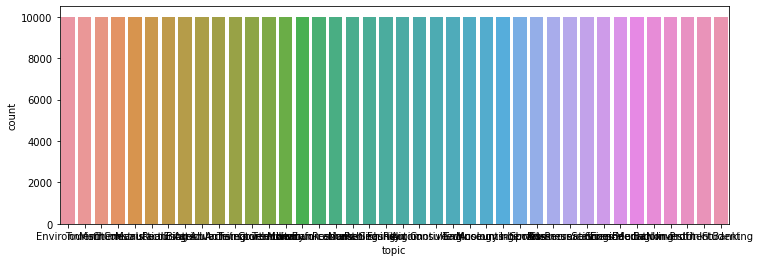

In [25]:
plt.figure(figsize=(12,4))
sns.countplot(downsampled.topic)
plt.show()

- we can observe now all topics are of same count

In [26]:
#converting int to objects
downsampled['age']=downsampled['age'].astype('object')
downsampled['id']=downsampled['id'].astype('object')
downsampled['AgeGroup']=downsampled['AgeGroup'].astype('object')

In [27]:
downsampled.shape

(400000, 8)

In [28]:
downsampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400000 entries, 473784 to 40417
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        400000 non-null  object
 1   gender    400000 non-null  object
 2   age       400000 non-null  object
 3   topic     400000 non-null  object
 4   sign      400000 non-null  object
 5   date      400000 non-null  object
 6   text      400000 non-null  object
 7   AgeGroup  400000 non-null  object
dtypes: object(8)
memory usage: 37.5+ MB


- All columns are object now

In [29]:
downsampled.sign.value_counts()

Cancer         38259
Scorpio        36658
Aries          36292
Taurus         36056
Virgo          35458
Libra          34536
Pisces         34414
Leo            30876
Sagittarius    30436
Gemini         30231
Aquarius       29660
Capricorn      27124
Name: sign, dtype: int64

In [30]:
downsampled.isna().sum()

id          0
gender      0
age         0
topic       0
sign        0
date        0
text        0
AgeGroup    0
dtype: int64

- No NULL values captured

<AxesSubplot:xlabel='age'>

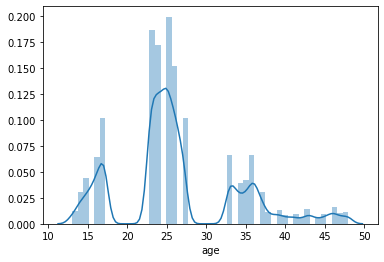

In [31]:
sns.distplot(downsampled['age'])

- Trying to capture the number of characters in the text and analyze if it has some significance


- Trying to observe number of characters and and there distribution

In [32]:
# examine the text characters length in test_df and record these
downsampled['text_length'] = downsampled['text'].str.len()

<AxesSubplot:xlabel='text_length'>

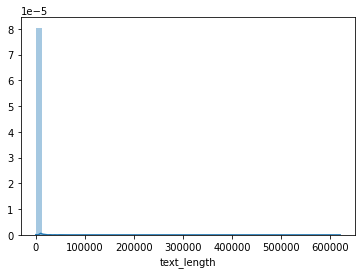

In [33]:
sns.distplot(downsampled['text_length'])

In [34]:
downsampled.head()

,id,gender,age,topic,sign,date,text,AgeGroup,text_length
473784,1705067,female,27,Environment,Pisces,"02,June,2004",I went to a poetry reading today....,20s,1656
302368,3718285,male,24,Environment,Gemini,"26,June,2004",urlLink This is mostly a ...,20s,105
303339,3885865,male,23,Environment,Scorpio,"10,July,2004",I would like to clarify that I am n...,20s,172
148655,4310237,female,33,Environment,Virgo,"23,August,2004","Now you can peek mine. Ah heh, ah heh-...",30s,430
303257,3885865,male,23,Environment,Scorpio,"29,July,2004",Many thanks for all of the birthday...,20s,448


In [35]:
pd.crosstab(downsampled.AgeGroup,downsampled.text_length)

text_length,4,5,6,7,8,9,10,11,12,13,...,92767,100146,104801,107585,122228,126168,128462,131862,207078,620448
AgeGroup,,,,,,,,,,,,,,,,,,,,,
10s,4,1,2,0,0,1,1,23,16,11,...,0,0,0,0,0,1,0,0,0,1
20s,9,17,1,11,5,10,11,136,44,31,...,0,1,1,0,0,0,0,1,3,0
30s,13,0,4,0,0,10,0,156,16,6,...,1,0,0,6,15,0,1,0,0,0


In [36]:
labels=['under1K','1kTo5k','5kTo10k','10Kto100K','100kAbove']
downsampled['text_length']=pd.cut(downsampled['text_length'],bins=[1,1000,5000,10000,100000,900000],labels=labels,right=False)

In [37]:
pd.crosstab(downsampled.AgeGroup,downsampled.text_length)

text_length,under1K,1kTo5k,5kTo10k,10Kto100K,100kAbove
AgeGroup,,,,,
10s,47569,22178,951,189,2
20s,141888,79999,4828,872,6
30s,61031,36735,3110,620,22


- This again is creating a biased view.
- majority of the blogs are short and under1k or under5k character length

In [38]:
downsampled['text_length']=downsampled['text_length'].astype('object')

In [39]:
#keeping raw data separate
import copy

data=copy.deepcopy(downsampled)

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400000 entries, 473784 to 40417
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           400000 non-null  object
 1   gender       400000 non-null  object
 2   age          400000 non-null  object
 3   topic        400000 non-null  object
 4   sign         400000 non-null  object
 5   date         400000 non-null  object
 6   text         400000 non-null  object
 7   AgeGroup     400000 non-null  object
 8   text_length  400000 non-null  object
dtypes: object(9)
memory usage: 30.5+ MB


In [41]:
#dropping Id and Date as these two are not charateristics of the blogger
#our goal is to predicts multiple features of the author of a given text

data.drop(['id','date'],axis=1,inplace=True)

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400000 entries, 473784 to 40417
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   gender       400000 non-null  object
 1   age          400000 non-null  object
 2   topic        400000 non-null  object
 3   sign         400000 non-null  object
 4   text         400000 non-null  object
 5   AgeGroup     400000 non-null  object
 6   text_length  400000 non-null  object
dtypes: object(7)
memory usage: 24.4+ MB


#### Data Preprocessing

- Data cleansing by removing unwanted characters, spaces, stop words etc. Convert text to lowercase.
- Target/label merger and transformation
- Train and test split
- Vectorisation, etc

In [43]:
import re # regex
#removing unwanted characters
#removing numbers as well
#data['processed_text']=data['text'].apply(lambda x: re.sub(r'[^A-Za-z0-9]+',' ',x))
data['processed_text']=data['text'].apply(lambda x: re.sub(r'[^A-Za-z]+',' ',x))

In [44]:
#converting to lower case
data['processed_text']=data['processed_text'].apply(lambda x: x.lower())
data['processed_text']=data['processed_text'].apply(lambda x: x.strip())

- data converted to small case

In [45]:
print(data['text'].iloc[0])
print()
print(data['processed_text'].iloc[0])

             I went to a poetry reading today.   Not suspecting that I would be chosen, I entered a contest to win tickets to attend a reading by poets who were shortlisted to win the  urlLink Griffin Poetry Prize .   I won.    Initial reaction:  Yay! I won something!   (Right now you're thinking: geez, this girl is some crazed artsy-fartsy type who's going to go on and on about poetic form, provide you with some pretentious review of the poets' works, then tell you who she thinks should win the prizes and why, etc, etc. You are SO wrong...)    A couple minutes later:  Ummm...what am I going to do? I don't know much about poetry at all! I mean, there are some poems that I like, but I might be totally lost in there. I'd feel quite silly then, wouldn't I?  ---  I went to the poetry reading with my sister. I saw her dose off a couple times, but I stayed awake. I actually liked the experience as a whole, and even liked and appreciated (with my limited knowledge) some of the poems. Of cours

In [46]:
#removing stop words
from nltk.corpus import stopwords
stopwords=set(stopwords.words('English'))

In [47]:
data['processed_text']=data['processed_text'].apply(lambda x: ' '.join([words 
                                                                        for words in x.split() 
                                                                        if words not in stopwords
                                                                       ]
                                                                      )
                                                   )

In [48]:
#making a label column, kept age group instead of age
#not keeping text length as its scwed towards short blogs

#keeping gender out as blogging is more gender neutral profession and less likely to impact the intellectual result of blog

#data['labels']=data.apply(lambda col: [col['AgeGroup'],col['topic'],col['sign']], axis=1)
data['labels']=data.apply(lambda col: [col['gender'],col['sign'],str(col['AgeGroup']),col['topic']], axis=1)

In [49]:
data.head()

,gender,age,topic,sign,text,AgeGroup,text_length,processed_text,labels
473784,female,27,Environment,Pisces,I went to a poetry reading today....,20s,1kTo5k,went poetry reading today suspecting would cho...,"[female, Pisces, 20s, Environment]"
302368,male,24,Environment,Gemini,urlLink This is mostly a ...,20s,under1K,urllink mostly test picture see things work nb...,"[male, Gemini, 20s, Environment]"
303339,male,23,Environment,Scorpio,I would like to clarify that I am n...,20s,under1K,would like clarify sagitarious born year money...,"[male, Scorpio, 20s, Environment]"
148655,female,33,Environment,Virgo,"Now you can peek mine. Ah heh, ah heh-...",30s,under1K,peek mine ah heh ah heh heh heh anyway urllink...,"[female, Virgo, 30s, Environment]"
303257,male,23,Environment,Scorpio,Many thanks for all of the birthday...,20s,under1K,many thanks birthday wishes think dan might wa...,"[male, Scorpio, 20s, Environment]"


In [50]:
data=data[['processed_text','labels']]

In [51]:
data.head()

,processed_text,labels
473784,went poetry reading today suspecting would cho...,"[female, Pisces, 20s, Environment]"
302368,urllink mostly test picture see things work nb...,"[male, Gemini, 20s, Environment]"
303339,would like clarify sagitarious born year money...,"[male, Scorpio, 20s, Environment]"
148655,peek mine ah heh ah heh heh heh anyway urllink...,"[female, Virgo, 30s, Environment]"
303257,many thanks birthday wishes think dan might wa...,"[male, Scorpio, 20s, Environment]"


In [52]:

#not able to train model because of memory issue
#data=data.sample(100000)
data=data.head(100000)

In [53]:
X=data['processed_text']
y=data['labels']

In [54]:
X.shape

(100000,)

In [55]:
from sklearn.feature_extraction.text import CountVectorizer

In [56]:
label_counts=dict()

for labels in data.labels.values:
    for label in labels:
        if label in label_counts:
            label_counts[label]+=1
        else:
            label_counts[label]=1

In [57]:
label_counts

{'female': 40005,
 'Pisces': 8561,
 '20s': 62010,
 'Environment': 10000,
 'male': 59995,
 'Gemini': 6992,
 'Scorpio': 11298,
 'Virgo': 9623,
 '30s': 18821,
 'Sagittarius': 5083,
 '10s': 19169,
 'Libra': 9150,
 'Aquarius': 9483,
 'Taurus': 11583,
 'Cancer': 9168,
 'Capricorn': 7098,
 'Tourism': 10000,
 'Aries': 7168,
 'Leo': 4793,
 'Maritime': 10000,
 'Chemicals': 10000,
 'Construction': 10000,
 'Manufacturing': 10000,
 'RealEstate': 10000,
 'Biotech': 10000,
 'Agriculture': 10000,
 'Advertising': 10000}

In [58]:
from sklearn.preprocessing import MultiLabelBinarizer
binarizer=MultiLabelBinarizer(classes=sorted(label_counts.keys()))

In [59]:
y=binarizer.fit_transform(data.labels)

In [60]:
y.shape

(100000, 27)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.15, random_state=0)
print('Training utterances: {}'.format(X_train.shape[0]))
print('Validation utterances: {}'.format(X_test.shape[0]))

Training utterances: 85000
Validation utterances: 15000


In [62]:
#https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes

#MultinomialNB implements the naive Bayes algorithm for multinomially distributed data, 
# and is one of the two classic naive Bayes variants used in text classification 
#(where the data are typically represented as word vector counts,
# although tf-idf vectors are also known to work well in practice). 


#vectorizer=CountVectorizer(binary=True, ngram_range=(1,2))
#X=vectorizer.fit_transform(X)

#vectorizer = TfidfVectorizer()
#vectorizer.fit(X)
#X = vectorizer.transform(X)

# We only fit on our X_train just as we do for the other models we have worked with in python. We want to train the model on just the training data and then all we want to do with the testing data is to transform it based on our training data. We still need both of these to be dataframes so we convert our matrices made in the fit to dense matrices so they can be made into dataframes easily.
# we took whole X as we will be taking a small sample downwards due to computation issues

#Attempted with countvectorizer as well as tfidf

In [63]:
vectorizer=CountVectorizer(binary=True, ngram_range=(1,2))
#vectorizer = TfidfVectorizer(binary=True, ngram_range=(1,2))
vectorizer.fit(X_train)

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [64]:
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)
X_train, X_test

(<85000x1348533 sparse matrix of type '<class 'numpy.int64'>'
 	with 15388883 stored elements in Compressed Sparse Row format>,
 <15000x1348533 sparse matrix of type '<class 'numpy.int64'>'
 	with 2715709 stored elements in Compressed Sparse Row format>)

In [65]:
X_train.shape

(85000, 1348533)

- After multiple iterations removed chi2 for feature selection as its hugely impacting the results if we reduce the size significantly.
- Created the data set with all it has.

In [66]:
#from sklearn.feature_selection import SelectKBest, chi2

#ch2 = SelectKBest(chi2, k=100000)
#X_train = ch2.fit_transform(X_train, y_train)
#X_test = ch2.transform(X_test)

#X_train, X_test

In [67]:
X_train.shape

(85000, 1348533)

In [68]:
y_train.shape

(85000, 27)

- Creating model with MultinomialNB as base classifier and OneVsRestClassifer for capturing multiple options

In [69]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

multuNB = OneVsRestClassifier(MultinomialNB())
multuNB.fit(X_train, y_train)

pred = multuNB.predict(X_test)
print(accuracy_score(y_test, pred))

0.8254666666666667


In [70]:
y_pred=multuNB.predict(X_test)
t = 0.7 # threshold value
y_pred_new = (y_pred >= t).astype(int)

y_pred_inversed = binarizer.inverse_transform(y_pred_new)
y_test_inversed = binarizer.inverse_transform(y_test)

import random
for i in range(5):
    ranVal=random.randint(1,101)
    print('True labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        ','.join(y_test_inversed[ranVal]),
        ','.join(y_pred_inversed[ranVal])
    ))

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

def print_evaluation_scores(Ytest, Ypred):
    print('Accuracy score: ', accuracy_score(Ytest, Ypred))
    print('F1 score: ', f1_score(Ytest, Ypred, average='micro'))
    print('Average precision score: ', average_precision_score(Ytest, Ypred, average='micro'))
    print('Average recall score: ', recall_score(Ytest, Ypred, average='micro'))

print_evaluation_scores(y_test, y_pred)

True labels:	10s,Aries,Tourism,female
Predicted labels:	10s,Aries,Tourism,female


True labels:	30s,Biotech,Capricorn,female
Predicted labels:	30s,Biotech,Capricorn,female


True labels:	20s,Agriculture,Capricorn,female
Predicted labels:	20s,Agriculture,Capricorn,female


True labels:	20s,Agriculture,Capricorn,female
Predicted labels:	20s,Agriculture,Capricorn,female


True labels:	20s,Biotech,Capricorn,male
Predicted labels:	20s,Biotech,Capricorn,male


Accuracy score:  0.8254666666666667
F1 score:  0.9197173327309981
Average precision score:  0.8541400105521758
Average recall score:  0.9500833333333333


In [71]:
from sklearn.externals import joblib 
  
# Save the model as a pickle in a file 
#joblib.dump(model, 'part1_v0.pkl') 
joblib.dump(multuNB, 'multuNB_V1.pkl') 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['multuNB_V1.pkl']

- Using BernoulliNB

In [72]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score


BernNB = OneVsRestClassifier(BernoulliNB())
BernNB.fit(X_train, y_train)

pred = BernNB.predict(X_test)
print(accuracy_score(y_test, pred))

0.42293333333333333


In [73]:
y_pred=BernNB.predict(X_test)
t = 0.3 # threshold value
y_pred_new = (y_pred >= t).astype(int)
y_pred_inversed = binarizer.inverse_transform(y_pred_new)
y_test_inversed = binarizer.inverse_transform(y_test)

for i in range(5):
    ranVal=random.randint(1,101)
    print('True labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        ','.join(y_test_inversed[ranVal]),
        ','.join(y_pred_inversed[ranVal])
    ))


print_evaluation_scores(y_test, y_pred)

True labels:	10s,Aries,Maritime,male
Predicted labels:	10s,Aries,Maritime,male


True labels:	20s,Agriculture,Aquarius,male
Predicted labels:	20s,Agriculture,Aquarius,male


True labels:	20s,Environment,Scorpio,male
Predicted labels:	20s,Environment,Scorpio,male


True labels:	10s,Maritime,Scorpio,male
Predicted labels:	10s,Maritime,Scorpio,male


True labels:	30s,RealEstate,Virgo,male
Predicted labels:	30s,RealEstate,Virgo,male


Accuracy score:  0.42293333333333333
F1 score:  0.7618246611925675
Average precision score:  0.6210061056010617
Average recall score:  0.7321833333333333


In [74]:
from sklearn.externals import joblib 
  
# Save the model as a pickle in a file 
#joblib.dump(model, 'part1_v0.pkl') 
joblib.dump(BernNB, 'BernNB_V1.pkl') 

['BernNB_V1.pkl']

In [75]:
y_test[0]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0])

In [76]:
y_test_inversed[0]

('20s', 'Environment', 'Pisces', 'female')

- Using RandomForestClassifer

In [79]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

clsRan=RandomForestClassifier(n_estimators=10, max_depth=10,
                             n_jobs=3,
                             random_state=0)

clsRan=OneVsRestClassifier(clsRan)

clsRan.fit(X_train,y_train)

pred = clsRan.predict(X_test)
print(accuracy_score(y_test, pred))

0.0019333333333333333


In [80]:
y_pred=clsRan.predict(X_test)
t = 0.3 # threshold value
y_pred_new = (y_pred >= t).astype(int)
y_pred_inversed = binarizer.inverse_transform(y_pred_new)
y_test_inversed = binarizer.inverse_transform(y_test)

for i in range(5):
    ranVal=random.randint(1,101)
    print('True labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        ','.join(y_test_inversed[ranVal]),
        ','.join(y_pred_inversed[ranVal])
    ))


print_evaluation_scores(y_test, y_pred)

True labels:	20s,Biotech,Virgo,male
Predicted labels:	20s,male


True labels:	30s,Manufacturing,Sagittarius,male
Predicted labels:	20s,male


True labels:	20s,Agriculture,Pisces,male
Predicted labels:	20s,male


True labels:	10s,Aquarius,Chemicals,female
Predicted labels:	20s,male


True labels:	20s,Biotech,Capricorn,male
Predicted labels:	20s,male


Accuracy score:  0.0019333333333333333
F1 score:  0.41769194139599786
Average precision score:  0.29720985761786783
Average recall score:  0.3143166666666667


In [81]:
from sklearn.externals import joblib 
  
# Save the model as a pickle in a file 
#joblib.dump(model, 'part1_v0.pkl') 
joblib.dump(clsRan, 'RandomForestClf_V1.pkl') 

['RandomForestClf_V1.pkl']

- Not able to use dense models with such a huge size in my local system
- to use Dense models we have to use chi2 to reduce the size from 1.3M cols to 5k/10k cols due to which its loosing lot of important data and leading to very low accuracy.

In [82]:
import gc
gc.collect()

1128

In [83]:
#!pip install scikit-multilearn

- Using KNN from Multi Learn

In [84]:
from skmultilearn.adapt import MLkNN
classifier = MLkNN(k=20)


classifier.fit(X_train,y_train)



MLkNN(ignore_first_neighbours=0, k=20, s=1.0)

In [85]:


y_pred=classifier.predict(X_test)
t = 0.3 # threshold value
y_pred_new = (y_pred >= t).astype(int)
y_pred_inversed = binarizer.inverse_transform(y_pred_new)
y_test_inversed = binarizer.inverse_transform(y_test)


for i in range(5):
    ranVal=random.randint(1,101)
    print('True labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        ','.join(y_test_inversed[ranVal]),
        ','.join(y_pred_inversed[ranVal])
    ))

def print_evaluation_scores_2(Ytest, Ypred):
    print('Accuracy score: ', accuracy_score(Ytest, Ypred))
    print('F1 score: ', f1_score(Ytest, Ypred, average='micro'))
    print('Average precision score: ', average_precision_score(Ytest, Ypred.toarray(), average='micro'))
    print('Average recall score: ', recall_score(Ytest, Ypred, average='micro')) 
print_evaluation_scores_2(y_test, y_pred_new)

True labels:	20s,Construction,Virgo,male
Predicted labels:	20s,Virgo,male


True labels:	20s,Scorpio,Tourism,male
Predicted labels:	20s,Biotech,Libra,male


True labels:	20s,Advertising,Gemini,female
Predicted labels:	20s,Gemini,female


True labels:	10s,Chemicals,Taurus,male
Predicted labels:	10s,Taurus,male


True labels:	10s,Biotech,Pisces,male
Predicted labels:	10s,Advertising,Taurus,male


Accuracy score:  0.33153333333333335
F1 score:  0.7011424481549597
Average precision score:  0.5479708873488955
Average recall score:  0.6449166666666667


In [86]:
from sklearn.externals import joblib 
  
# Save the model as a pickle in a file 
#joblib.dump(model, 'part1_v0.pkl') 
joblib.dump(classifier, 'MLkNN_v1.pkl') 

['MLkNN_v1.pkl']

In [87]:
import gc
gc.collect()

40

In [88]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

model=LogisticRegression(solver='lbfgs', max_iter=1000)

model=OneVsRestClassifier(model)

model.fit(X_train,y_train)


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [89]:
y_pred=model.predict(X_test)
t = 0.4 # threshold value
y_pred_new = (y_pred >= t).astype(int)
y_pred_inversed = binarizer.inverse_transform(y_pred_new)
y_test_inversed = binarizer.inverse_transform(y_test)


for i in range(5):
    ranVal=random.randint(1,101)
    print('True labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        ','.join(y_test_inversed[ranVal]),
        ','.join(y_pred_inversed[ranVal])
    ))

print_evaluation_scores(y_test, y_pred)

True labels:	10s,RealEstate,Virgo,male
Predicted labels:	10s,RealEstate,Virgo,male


True labels:	20s,Environment,Scorpio,male
Predicted labels:	20s,Environment,Scorpio,male


True labels:	10s,Aries,Maritime,male
Predicted labels:	10s,Aries,Maritime,male


True labels:	20s,Scorpio,Tourism,male
Predicted labels:	20s,Scorpio,Tourism,male


True labels:	20s,Agriculture,Aquarius,male
Predicted labels:	20s,Agriculture,Aquarius,male


Accuracy score:  0.9303333333333333
F1 score:  0.9711843072322235
Average precision score:  0.9495969311767468
Average recall score:  0.9580166666666666


In [90]:
joblib.dump(model,'LogisticReg_v1.pkl') 

['LogisticReg_v1.pkl']

 - We can observe we are able to get highest accuracy,precison,recall and F1 score for Logistic regression and Multinomial NB with OneVsRestClassifier.
 - True labels and predicted labels are very accurate.
 - Multinomial NB was much faster to compute compared to logistic regression but accuracies are better in Logistic regression